# Extract NECOFS water levels using NetCDF4-Python and analyze/visualize with Pandas

In [14]:
# Plot forecast water levels from NECOFS model from list of lon,lat locations
# (uses the nearest point, no interpolation)
import netCDF4
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from StringIO import StringIO
%matplotlib inline

In [15]:
#NECOFS MassBay grid
model='Massbay'
#url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc'
# GOM3 Grid
#model='GOM3'
url='http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'

In [16]:
# Enter desired (Station, Lat, Lon) values here:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Scituate Harbor,    42.199447, -70.720090
Scituate Beach,     42.209973, -70.724523
Falmouth Harbor,    41.541575, -70.608020
Marion,             41.689008, -70.746576
Marshfield,         42.108480, -70.648691
Provincetown,       42.042745, -70.171180
Sandwich,           41.767990, -70.466219
Hampton Bay,        42.900103, -70.818510
Gloucester,         42.610253, -70.660570
'''

In [17]:
def dms2dd(d,m,s):
    return d+(m+s/60.)/60.
  

In [18]:
dms2dd(41,33,15.7)

41.55436111111111

In [19]:
-dms2dd(70,30,20.2)

-70.50561111111111

In [20]:
x = '''
Station, Lat, Lon
Falmouth Harbor,    41.541575, -70.608020
Sage Lot Pond, 41.554361, -70.505611
'''

In [21]:
x = '''
Station, Lat, Lon
Boston,             42.368186, -71.047984
Carolyn Seep Spot,    39.8083, -69.5917
Falmouth Harbor,  41.541575, -70.608020
'''

In [22]:
# Create a Pandas DataFrame
obs=pd.read_csv(StringIO(x.strip()), sep=",\s*",index_col='Station')

-c:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [23]:
obs

,Lat,Lon
Station,,
Boston,42.368186,-71.047984
Carolyn Seep Spot,39.808300,-69.591700
Falmouth Harbor,41.541575,-70.608020


In [24]:
# find the indices of the points in (x,y) closest to the points in (xi,yi)
def nearxy(x,y,xi,yi):
    ind = np.ones(len(xi),dtype=int)
    for i in np.arange(len(xi)):
        dist = np.sqrt((x-xi[i])**2+(y-yi[i])**2)
        ind[i] = dist.argmin()
    return ind

In [25]:
# open NECOFS remote OPeNDAP dataset 
nc=netCDF4.Dataset(url).variables

In [26]:
# find closest NECOFS nodes to station locations
obs['0-Based Index'] = nearxy(nc['lon'][:],nc['lat'][:],obs['Lon'],obs['Lat'])
obs

,Lat,Lon,0-Based Index
Station,,,
Boston,42.368186,-71.047984,51703
Carolyn Seep Spot,39.808300,-69.591700,5074
Falmouth Harbor,41.541575,-70.608020,44738


In [27]:
# get time values and convert to datetime objects
times = nc['time']
jd = netCDF4.num2date(times[:],times.units)

In [31]:
# get all time steps of water level from each station
nsta = len(obs)
z = np.ones((len(jd),nsta))
for i in range(nsta):
    z[:,i] = nc['zeta'][:,obs['0-Based Index'][i]]
    

In [32]:
# make a DataFrame out of the interpolated time series at each location
zvals=pd.DataFrame(z,index=jd,columns=obs.index)

In [33]:
# list out a few values
zvals.head()

Station,Boston,Carolyn Seep Spot,Falmouth Harbor
2016-06-20 00:00:00.000,0.279748,0.657395,0.707420
2016-06-20 01:01:52.500,0.784970,0.538741,0.706830
2016-06-20 01:58:07.500,1.312351,0.326673,0.594273
2016-06-20 03:00:00.000,1.563488,0.069193,0.440999
2016-06-20 04:01:52.500,1.668126,-0.177511,0.368976


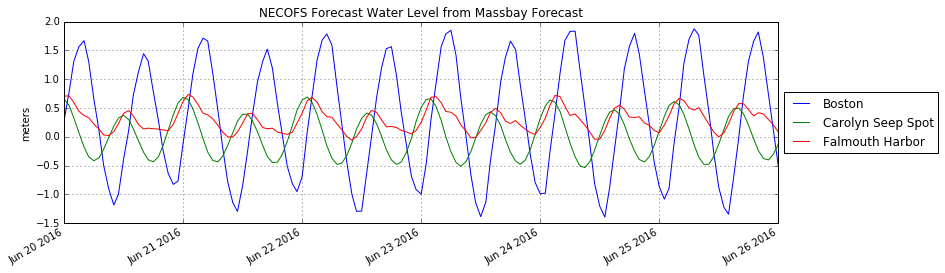

In [35]:
# plotting at DataFrame is easy!
ax=zvals.plot(figsize=(16,4),grid=True,title=('NECOFS Forecast Water Level from %s Forecast' % model),legend=False);
# read units from dataset for ylabel
plt.ylabel(nc['zeta'].units)
# plotting the legend outside the axis is a bit tricky
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));


In [36]:
# what is the maximum water level at Scituate over this period?
zvals['Boston'].max()

1.8749895095825195

In [37]:
# make a new DataFrame of maximum water levels at all stations
b=pd.DataFrame(zvals.idxmax(),columns=['time of max water level (UTC)'])
# create heading for new column containing max water level
zmax_heading='zmax (%s)' % nc['zeta'].units
# Add new column to DataFrame
b[zmax_heading]=zvals.max()

In [38]:
b

,time of max water level (UTC),zmax (meters)
Station,,
Boston,2016-06-25 07:01:52.500,1.874990
Carolyn Seep Spot,2016-06-22 01:01:52.500,0.690070
Falmouth Harbor,2016-06-21 01:01:52.500,0.734735
